# Running Mask RCNN  Detectron2 Model on Blood Cell Dataset

In [1]:
# Importing modules
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import matplotlib.pyplot as plt
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode  

/home/user/miniconda3/envs/detectron2/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (None) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# Function to visualize images
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

In [3]:
# Function to register image datasets 
def get_blood_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            region_attributes = anno["region_attributes"]["type"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            
            if "wbc" in region_attributes:
                category_id = 1
            elif "rbc" in region_attributes:
                category_id = 0
                
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


for d in ["train", "val"]:
    DatasetCatalog.register("blood_" + d, lambda d=d: get_blood_dicts("mydata/blood/" + d))
    MetadataCatalog.get("blood_" + d).set(thing_classes=["rbc", "wbc"])

blood_metadata = MetadataCatalog.get("blood_train")

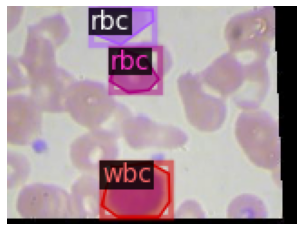

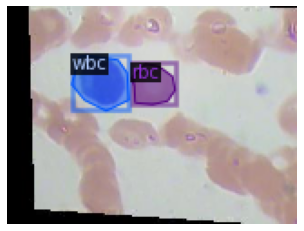

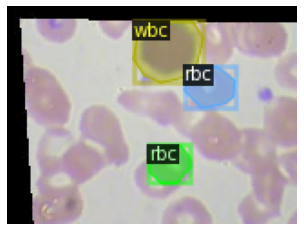

In [4]:
# Visualizing annotations in training set (Random samples)
dataset_dicts = get_blood_dicts("mydata/blood/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=blood_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [5]:
# Model configuration
cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda:0"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("blood_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 300 
cfg.SOLVER.STEPS = []   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 

# Setting up output dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [6]:
# Training model
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/22 10:59:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[08/22 10:59:38 d2.engine.train_loop]: Starting training from iteration 0


/home/user/miniconda3/envs/detectron2/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/22 10:59:42 d2.utils.events]:  eta: 0:00:39  iter: 19  total_loss: 2.463  loss_cls: 1.056  loss_box_reg: 0.6465  loss_mask: 0.6966  loss_rpn_cls: 0.05898  loss_rpn_loc: 0.01453    time: 0.1515  last_time: 0.1312  data_time: 0.0066  last_data_time: 0.0032   lr: 1.6068e-05  max_mem: 2244M
[08/22 10:59:45 d2.utils.events]:  eta: 0:00:36  iter: 39  total_loss: 2.22  loss_cls: 0.8643  loss_box_reg: 0.6559  loss_mask: 0.664  loss_rpn_cls: 0.03383  loss_rpn_loc: 0.01291    time: 0.1473  last_time: 0.1559  data_time: 0.0027  last_data_time: 0.0029   lr: 3.2718e-05  max_mem: 2245M
[08/22 10:59:48 d2.utils.events]:  eta: 0:00:33  iter: 59  total_loss: 2.028  loss_cls: 0.6499  loss_box_reg: 0.7433  loss_mask: 0.5933  loss_rpn_cls: 0.02464  loss_rpn_loc: 0.01413    time: 0.1424  last_time: 0.1455  data_time: 0.0025  last_data_time: 0.0024   lr: 4.9367e-05  max_mem: 2246M
[08/22 10:59:51 d2.utils.events]:  eta: 0:00:30  iter: 79  total_loss: 1.881  loss_cls: 0.5603  loss_box_reg: 0.7667  loss_m

In [7]:
# Saving model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 

In [8]:
# Perform prediction

# Threshold for predicting classes
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Setting up predictor
predictor = DefaultPredictor(cfg)
cfg.DETECTIONS_PER_IMAGE=100

# Reading new image
im = cv2.imread("mydata/blood.jpg")

# Prediction output
outputs = predictor(im)

[08/22 11:00:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


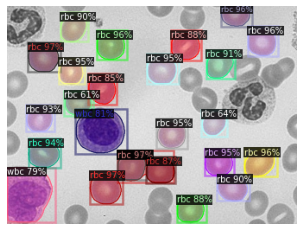

In [9]:
# Visualizing prediction output
v = Visualizer(im[:, :, ::-1], metadata=blood_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])